In [2]:
from torchdrug import transforms
from torchdrug import data, core, layers, tasks, metrics, utils, models
from torchdrug.layers import functional
from torchdrug.core import Registry as R

import torch
from torch.utils import data as torch_data
from torch.nn import functional as F
from lib.tasks import NodePropertyPrediction
from lib.datasets import ATPBind
from transformers import BertModel, BertTokenizer

truncuate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view='residue')
transform = transforms.Compose([truncuate_transform, protein_view_transform])

dataset = ATPBind(atom_feature=None, bond_feature=None,
                  residue_feature="default", transform=transform)

train_set, valid_set, test_set = dataset.split()


def _freeze_bert(
    bert_model: BertModel, freeze_bert=True, freeze_layer_count=-1
):
    """Freeze parameters in BertModel (in place)

    Args:
        bert_model: HuggingFace bert model
        freeze_bert: Bool whether or not to freeze the bert model
        freeze_layer_count: If freeze_bert, up to what layer to freeze.

    Returns:
        bert_model
    """
    if freeze_bert:
        # freeze the entire bert model
        for param in bert_model.parameters():
            param.requires_grad = False
    else:
        # freeze the embeddings
        for param in bert_model.embeddings.parameters():
            param.requires_grad = False
        if freeze_layer_count != -1:
            # freeze layers in bert_model.encoder
            for layer in bert_model.encoder.layer[:freeze_layer_count]:
                for param in layer.parameters():
                    param.requires_grad = False
    return None

# Cusom model Wrapping BERT: check https://torchdrug.ai/docs/notes/model.html


class BertWrapModel(torch.nn.Module, core.Configurable):
    def __init__(self):
        super().__init__()
        self.bert_tokenizer = BertTokenizer.from_pretrained(
            "Rostlab/prot_bert", do_lower_case=False)
        self.bert_model = BertModel.from_pretrained(
            "Rostlab/prot_bert").to('cuda')
        _freeze_bert(self.bert_model, freeze_bert=True, freeze_layer_count=-1)
        self.input_dim = 21
        self.output_dim = self.bert_model.config.hidden_size

    def forward(self, graph, _, all_loss=None, metric=None):
        # print("graph: ", graph)
        # print("sequence: ", graph.to_sequence())
        input = [seq.replace('.', ' ') for seq in graph.to_sequence()]

        encoded_input = self.bert_tokenizer(
            input, return_tensors='pt').to('cuda')
        # print("Input size: ", encoded_input["input_ids"].size())
        x = self.bert_model(**encoded_input)
        # print("Output size just after model: ", x.last_hidden_state.size())

        # skip residue feature for [CLS] and [SEP], since they are not in the original sequence
        return {"residue_feature": torch.squeeze(x.last_hidden_state)[1:-1]}


Split num:  [346, 42, 41]


In [17]:
bert_wrap_model = BertWrapModel()
bert_task = NodePropertyPrediction(
    bert_wrap_model, 
    normalization=False,
    num_mlp_layer=2,
    metric=("micro_auroc", "micro_auprc", "macro_auprc", "macro_auroc")
)
optimizer = torch.optim.Adam(bert_task.parameters(), lr=1e-3)
solver = core.Engine(bert_task, train_set, valid_set, test_set, optimizer, batch_size=1, log_interval=100000, gpus=[0])
ls = [solver.evaluate("test")]
for i in range(10):
    solver.train(num_epoch=1)
    res = solver.evaluate("test")
    ls.append(res)


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


21:12:23   Preprocess training set
21:12:24   {'batch_size': 1,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100000,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'class': 'optim.Adam',
               'eps': 1e-08,
               'lr': 0.001,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'NodePropertyPrediction',
          'criterion': 'bce',
          'metric': ('micro_auroc',
                     'micro_auprc',
                     'macro_auprc',
                     'macro_auroc'),
          'model': {'class': 'BertWrapModel'},
          'normalization': False,
          'num_class': None,
          'num_mlp_layer': 2,
          'verbose': 0},
 'test_set': {'class': 'dataset.Subset',
              'dataset': {'atom_feature': None,
                          'bond_feature': None,
                          'class': 'ATPBind',
                  

In [20]:
# bce is captured from standard output of the previous cell
bce = [0.671425, 0.176834, 0.14809, 0.138288, 0.129046, 0.117494, 0.102882, 0.0896337, 0.0725132, 0.0604685, 0.0448919]
auroc = [i['micro_auroc'].item() for i in ls]

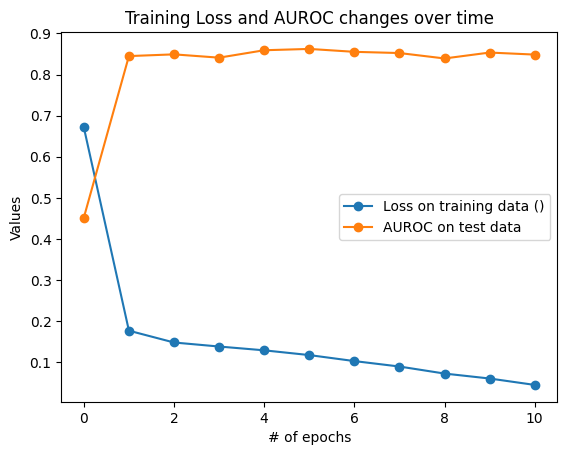

In [21]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
# Create an array for the x-axis representing the index of each element in the arrays
x = np.arange(len(bce))

# Plot the lines for bce and auroc
plt.plot(x, bce, label='Loss on training data (BCE)', marker='o')
plt.plot(x, auroc, label='AUROC on test data', marker='o')

# Set up the labels and title for the chart
plt.xlabel('# of epochs')
plt.ylabel('Values')
plt.title('Training Loss and AUROC changes over time')

# Add a legend to indicate which line represents which array
plt.legend()

# Display the chart
plt.show()
